In [1]:
pip install opencv-python

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.




[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from copy import deepcopy

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights

from sklearn.model_selection import train_test_split

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image
import os
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [7]:
pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
label_index = {"dry": 0, "normal": 1, "oily": 2}
index_label = {0: "dry", 1: "normal", 2: "oily"}


In [9]:
def create_df(base):
    dd = {"images": [], "labels": []}
    for i in os.listdir(base):
        label = os.path.join(base, i)
        for j in os.listdir(label):
            img = os.path.join(label, j)
            dd["images"] += [img]
            dd["labels"] += [label_index[i]]
    return pd.DataFrame(dd)

In [10]:
train_df = create_df(r"D:\Codes\OilDetection_codes\Oily-Dry-Skin-Types\train")
val_df = create_df(r"D:\Codes\OilDetection_codes\Oily-Dry-Skin-Types\valid")
test_df = create_df(r"D:\Codes\OilDetection_codes\Oily-Dry-Skin-Types\test")

In [11]:
train_df = pd.concat([train_df, val_df, test_df])

In [12]:
EPOCHS = 10
LR = 0.1
STEP = 15
GAMMA = 0.1
BATCH = 64
OUT_CLASSES = 3
IMG_SIZE = 224

In [13]:
from torch.utils.data import Dataset
from PIL import Image
import numpy as np

class CloudDS(Dataset):
    def __init__(self, data, transform):
        super(CloudDS, self).__init__()
        self.data = data
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, x):
        img, label = self.data.iloc[x, 0], self.data.iloc[x, 1]
        img = Image.open(img).convert("RGB")
        img = self.transform(np.array(img))
        
        return img, label

In [14]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                                transforms.RandomVerticalFlip(0.6),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

transform = transforms.Compose([transforms.ToPILImage(),
                               transforms.ToTensor(),
                               transforms.Resize((IMG_SIZE, IMG_SIZE)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                     std=[0.229, 0.224, 0.225])])

In [15]:
train, testing = train_test_split(train_df, random_state=42, test_size=0.2)
val, test = train_test_split(testing, random_state=42, test_size=0.5)

In [16]:
train_ds = CloudDS(train, train_transform)
val_ds = CloudDS(val, transform)

In [17]:
train_dl = DataLoader(train_ds, batch_size=BATCH, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=BATCH, shuffle=False)

In [18]:
resnet = resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
num_ftrs = resnet.fc.in_features
resnet.fc.in_features = nn.Linear(num_ftrs, OUT_CLASSES)

In [19]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [ ]:
model = deepcopy(resnet)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=STEP, gamma=GAMMA)

: 

In [ ]:
best_model = deepcopy(model)
best_acc = 0

train_loss = []
train_acc = []
val_loss = []
val_acc = []

for i in range(1, EPOCHS+1):
    model.train()
    
    diff = 0
    total = 0
    acc = 0
    
    for data, target in train_dl:
        optimizer.zero_grad()
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        out = model(data)
        loss = criterion(out, target)
        diff += loss.item()
        acc += (out.argmax(1) == target).sum().item()
        total += out.size(0)
        loss.backward()
        optimizer.step()
        
    train_loss += [diff/total]
    train_acc += [acc/total]
    
    model.eval()
    
    diff = 0
    total = 0
    acc = 0
    
    with torch.no_grad():
        for data, target in val_dl:
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()
                
            out = model(data)
            loss = criterion(out, target)
            diff += loss.item()
            acc += (out.argmax(1) == target).sum().item()
            total += out.size(0)
            
    val_loss += [diff/total]
    val_acc += [acc/total]
    
    if val_acc[-1] > best_acc:
        best_acc = val_acc[-1]
        best_model = deepcopy(model)
        
    scheduler.step()
    
    print("Epochs {} train loss {} acc {} val loss {} acc {}".format(i, train_loss[-1],
                                                                    train_acc[-1], val_loss[-1],
                                                                    val_acc[-1]))

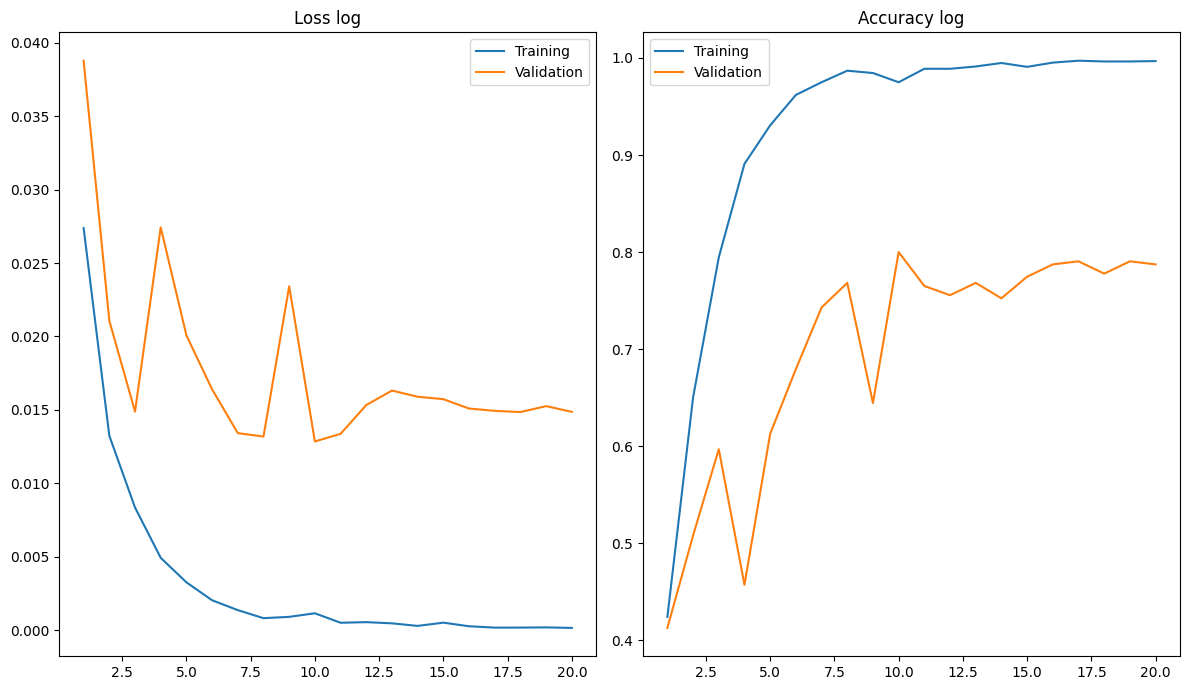

In [ ]:
epochs = list(range(1, EPOCHS+1))
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 7))
axes[0].plot(epochs, train_loss)
axes[0].plot(epochs, val_loss)
axes[0].legend(["Training", "Validation"])
axes[0].set_title("Loss log")

axes[1].plot(epochs, train_acc)
axes[1].plot(epochs, val_acc)
axes[1].legend(["Training", "Validation"])
axes[1].set_title("Accuracy log")

plt.tight_layout()
plt.show()

In [ ]:
def predict(x):
    img = Image.open(x).convert("RGB")
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        
        return out.argmax(1).item()

In [ ]:
pred = []
truth = []

for i in range(test.shape[0]):
    pred += [predict(test.iloc[i, 0])]
    truth += [test.iloc[i, 1]]

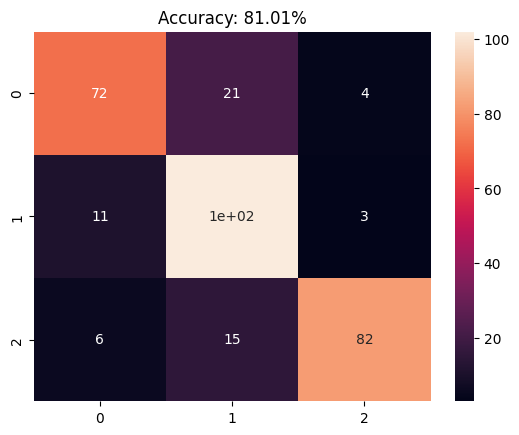

In [ ]:
score = accuracy_score(truth, pred)
report = classification_report(truth, pred)
cm = confusion_matrix(truth, pred)
sns.heatmap(cm, annot=True)
plt.title("Accuracy: {}%".format(round(score*100, 2)))
plt.show()

In [ ]:
print(report)

              precision    recall  f1-score   support

           0       0.81      0.74      0.77        97
           1       0.74      0.88      0.80       116
           2       0.92      0.80      0.85       103

    accuracy                           0.81       316
   macro avg       0.82      0.81      0.81       316
weighted avg       0.82      0.81      0.81       316



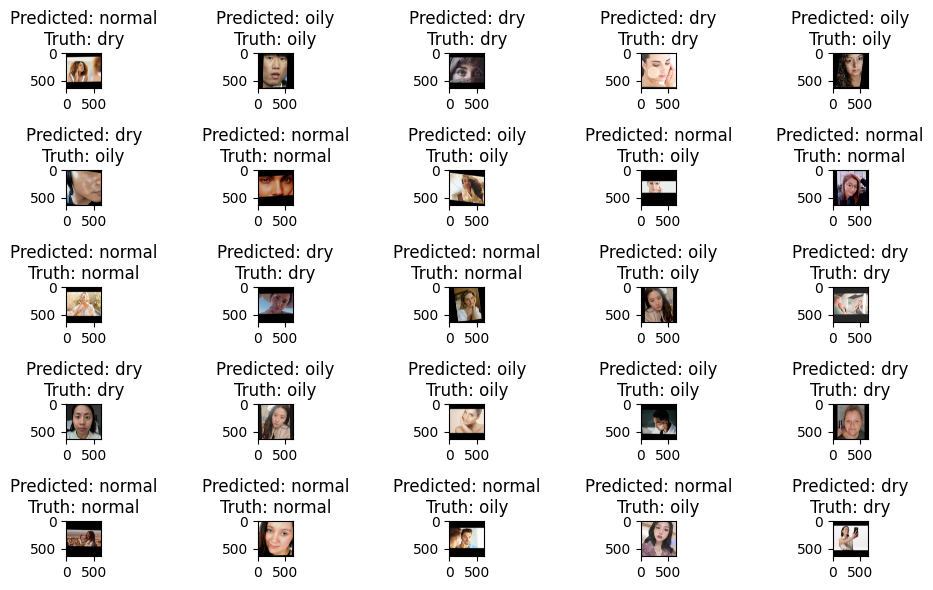

In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 6))
index = 0
for i in range(5):
    for j in range(5):
        img = test.iloc[index, 0]
        img = Image.open(img).convert("RGB")
        axes[i][j].imshow(img)
        axes[i][j].set_title("Predicted: {}\nTruth: {}".format(index_label[pred[index]], index_label[truth[index]]))
        index += 1
        
plt.tight_layout()
plt.show()

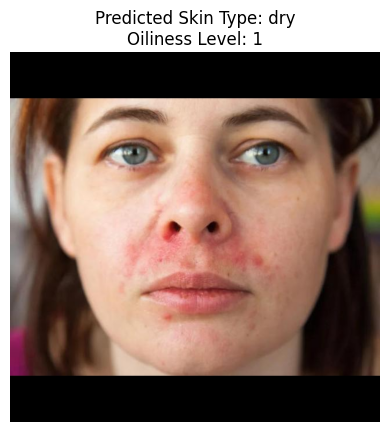

In [ ]:
def predict_skin_type_and_oiliness_level(image_path):
    img = Image.open(image_path).convert("RGB")
    original_img = deepcopy(img)
    img = transform(np.array(img))
    img = img.view(1, 3, 224, 224)
    best_model.eval()
    with torch.no_grad():
        if torch.cuda.is_available():
            img = img.cuda()
        
        out = best_model(img)
        skin_type = index_label[out.argmax(1).item()]
        oiliness_level = get_oiliness_level(out.cpu().numpy())
        
        return original_img, skin_type, oiliness_level

def get_oiliness_level(predictions):
    oiliness_index = np.argmax(predictions)
    # Assuming the predictions are in the order of dry, normal, oily
    if oiliness_index == 0:
        return 1  # Dry or very low
    elif oiliness_index == 1:
        return 2  # Low
    elif oiliness_index == 2:
        return 3  # Medium
    else:
        return 4  # Very high

image_path = r"D:\Codes\OilDetection_codes\Oily-Dry-Skin-Types\test\dry\dry_3cff4d4b05b7b88def12_jpg.rf.61f7ed0c6569bde348734178e19a55f7.jpg"
original_img, skin_type, oiliness_level = predict_skin_type_and_oiliness_level(image_path)

# Show the original image
plt.imshow(original_img)
plt.title("Predicted Skin Type: {}\nOiliness Level: {}".format(skin_type, oiliness_level))
plt.axis("off")
plt.show()


In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# Function to load images from multiple folders
def load_images_from_folders(folders):
    images = []
    for folder_path in folders:
        if os.path.exists(folder_path):
            for filename in os.listdir(folder_path):
                img_path = os.path.join(folder_path, filename)
                if os.path.isfile(img_path):
                    img = cv2.imread(img_path)
                    if img is not None:
                        images.append(img)
    return images

# Path to image folders
dry_skin_folder = r'D:\Codes\OilDetection_codes\Oily-Dry-Skin-Types\valid\dry'
normal_skin_folder = r'D:\Codes\OilDetection_codes\Oily-Dry-Skin-Types\valid\normal'
oily_skin_folder = r'D:\Codes\OilDetection_codes\Oily-Dry-Skin-Types\valid\oily'

# Load images from multiple folders
image_folders = [dry_skin_folder, normal_skin_folder, oily_skin_folder]
images = load_images_from_folders(image_folders)

# Plot images from different folders
plt.figure(figsize=(15, 10))
for folder_path, img in zip(image_folders, images):
    folder_name = os.path.basename(folder_path)
    plt.subplot(1, len(image_folders), image_folders.index(folder_path) + 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Folder: {folder_name}')
plt.show()


In [ ]:
import cv2

# Function to detect oiliness level
def detect_oiliness_level(oiliness_percentage):
    if oiliness_percentage < 10:
        return 1
    elif oiliness_percentage < 30:
        return 2
    elif oiliness_percentage < 60:
        return 3
    else:
        return 4

# Function to detect oiliness in a face
def detect_oiliness(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.bilateralFilter(gray, 11, 75, 75)
    edges = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 7)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) > 0:
        total_pixels = gray.size
        oily_pixels = sum(cv2.contourArea(cnt) for cnt in contours)
        oiliness_percentage = (oily_pixels / total_pixels) * 100
    else:
        oiliness_percentage = 0
    
    return oiliness_percentage

# Open the camera
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()  # Read a frame from the camera

    if not ret:
        print("Failed to capture frame.")
        break

    oiliness_percentage = detect_oiliness(frame)  # Detect oiliness in the frame
    oiliness_level = detect_oiliness_level(oiliness_percentage)  # Detect oiliness level

    # Display the frame with oiliness level
    cv2.putText(frame, f"Oiliness Level: {oiliness_level}", (50, 50),
                cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

    cv2.imshow('Face Oiliness Detection', frame)

    # Break the loop when 'q' is pressed
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the camera and close all OpenCV windows
cap.release()
cv2.destroyAllWindows()
